In [8]:
%run ./function.ipynb

In [10]:
PATH = "D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/"
FILE = "TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv"
df = pd.read_csv(PATH+FILE)
df.columns

Index(['alert_id', 'run_date', 'primary_entity_level_code',
       'primary_entity_number', 'scenario_name', 'TO_SAR', 'Acct_No',
       'Cust_No', 'Cust_Key', 'Cust_Segmentation', 'Cust_Typ_Cd', 'Cust_Id_Id',
       'Cust_Id_Typ_Desc', 'Cust_Id_State_Cd', 'Cust_Dt_Of_Birth',
       'Cust_Sts_Desc', 'Street_Postal_Cd', 'Street_Cntry_Cd',
       'Mailing_Postal_Cd', 'Mailing_Cntry_Cd', 'Residence_Cntry_Cd',
       'Citizenship_Cntry_Cd', 'Org_Cntry_Of_Buz_Cd', 'Empl_No', 'Ocup_Code',
       'job_title_code', 'Lst_Cont_Dt', 'Politically_Exposed_Pers_Ind',
       'Non_Prft_Org_Ind', 'Cust_Since_Dt', 'Lst_Susp_Actv_Rpt_Dt',
       'Extnl_Cust_Ind', 'Negative_News_Ind', 'Prim_Br_No', 'Obu_Ind',
       'Riskclass_Cd', 'risk_score', 'last_risk_assessment_date',
       'change_current_ind', 'change_begin_date', 'change_end_date',
       'Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'],
      dtype='object')

In [13]:
df['TO_SAR'] = df['TO_SAR'].replace(np.nan, 0)
df['TO_SAR'] = df['TO_SAR'].replace('F', 1)
df['TO_SAR'] = df['TO_SAR'].replace('NF', 1)

In [14]:
SAR_type = 'TO_SAR'
train_set, test_set = ReadFile(df, SAR_type)

Verify on time series
shape of data: (86770, 39)
total number of TO_SAR: 446
********************************
time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 267
TO_SAR/Total in train set 0.005128599143312653
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 179
TO_SAR/Total in test set 0.0051571638479933155
********************************
train data shape:  (52061, 38)
test data shape:  (34709, 38)


In [15]:
SAR = train_set[train_set['TO_SAR']!=0]
Non_SAR = train_set[train_set['TO_SAR']==0]

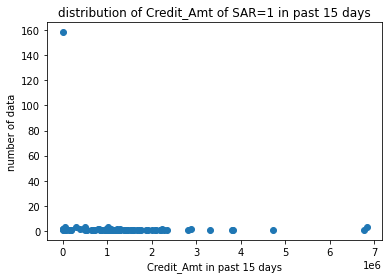

In [16]:
feature = 'Credit_Amt'
day = 15
label = 1
DrawFeatureDistribution(SAR, feature, day, label)

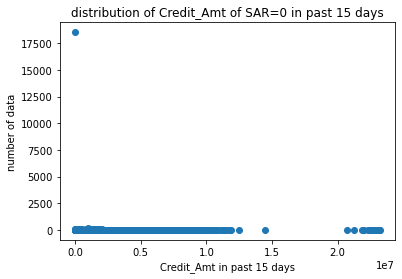

In [18]:
feature = 'Credit_Amt'
day = 15
label = 0
DrawFeatureDistribution(Non_SAR, feature, day, label)

In [19]:
# credit 存款, 小於等於{金額}留下, SAR=0 Credit_Amt值較大, upper bound
# train set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
threshold_range1 = np.arange(1e6, 1e7, 1e6)
for thre in threshold_range1:
    new_SAM_1 = train_set[train_set['Credit_Amt']<=thre] 
    new_SAM_0 = train_set[train_set['Credit_Amt']>thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
    total = train_set.shape[0]
    results = results.append({'threshold':thre, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,1000000.0,267,51794,206,28117,61,23676,0.7715,0.4559
1,2000000.0,267,51794,247,44742,20,7051,0.9251,0.1358
2,3000000.0,267,51794,259,49137,8,2656,0.97,0.0512
3,4000000.0,267,51794,262,50229,5,1564,0.9813,0.0301
4,5000000.0,267,51794,263,50809,4,984,0.985,0.019
5,6000000.0,267,51794,263,51201,4,592,0.985,0.0114
6,7000000.0,267,51794,267,51407,0,386,1.0,0.0074
7,8000000.0,267,51794,267,51526,0,267,1.0,0.0051
8,9000000.0,267,51794,267,51695,0,98,1.0,0.0019


In [20]:
# test set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 2e6

new_SAM_1 = test_set[test_set['Credit_Amt']<=thre] 
new_SAM_0 = test_set[test_set['Credit_Amt']>thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
total = test_set.shape[0]
results = results.append({'threshold':thre, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                          'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                          'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                          'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                          'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,2000000.0,179,34530,172,29689,7,4841,0.9609,0.1397


### threshold: 現金次數>=&1101_trans_num次

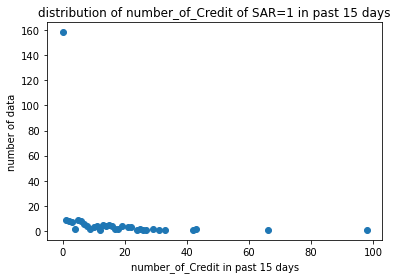

In [21]:
feature = 'number_of_Credit'
day = 15
label = 1
DrawFeatureDistribution(SAR, feature, day, label)

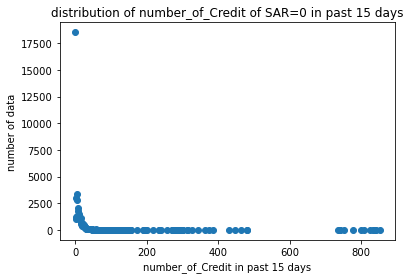

In [23]:
feature = 'number_of_Credit'
day = 15
label = 0
DrawFeatureDistribution(Non_SAR, feature, day, label)

In [26]:
# credit 存款次數, 小於等於{次數}留下, SAR = 0 number_of_Credit值比較大, upper bound
# train set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

for thre in np.arange(10, 210, 20):
    new_SAM_1 = train_set[train_set['number_of_Credit']<=thre] 
    new_SAM_0 = train_set[train_set['number_of_Credit']>thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
    total = train_set.shape[0]
    results = results.append({'threshold':thre, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,10,267,51794,216,37743,51,14050,0.809,0.2709
1,30,267,51794,260,49135,7,2658,0.9738,0.0512
2,50,267,51794,265,50853,2,940,0.9925,0.0181
3,70,267,51794,266,51371,1,422,0.9963,0.0081
4,90,267,51794,266,51474,1,319,0.9963,0.0061
5,110,267,51794,267,51523,0,270,1.0,0.0052
6,130,267,51794,267,51561,0,232,1.0,0.0045
7,150,267,51794,267,51661,0,132,1.0,0.0025
8,170,267,51794,267,51680,0,113,1.0,0.0022
9,190,267,51794,267,51682,0,111,1.0,0.0021


In [28]:
# test set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
thre = 30
new_SAM_1 = test_set[test_set['number_of_Credit']<=thre] 
new_SAM_0 = test_set[test_set['number_of_Credit']>thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
total = test_set.shape[0]
results = results.append({'threshold':thre, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                          'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                          'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                          'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                          'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,30,179,34530,177,32835,2,1695,0.9888,0.0489


### threshold: 現金提款累計>=&1101_amount元

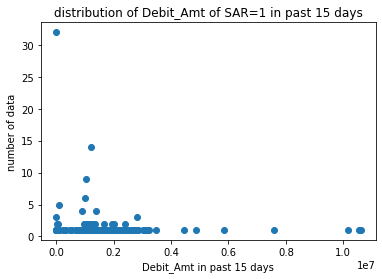

In [29]:
feature = 'Debit_Amt'
day = 15
label = 1
DrawFeatureDistribution(SAR, feature, day, label)

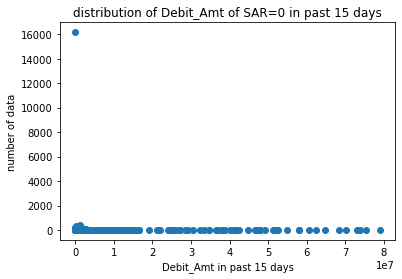

In [31]:
feature = 'Debit_Amt'
day = 15
label = 0
DrawFeatureDistribution(Non_SAR, feature, day, label)

In [32]:
# debit 提款金額 小於等於{金額}留下, SAR=0 Debit_Amt值較大, upper bound
# train set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
threshold_range3 = np.arange(1e6, 1e7, 1e6)
for thre in threshold_range3:
    new_SAM_1 = train_set[train_set['Debit_Amt']<=thre] 
    new_SAM_0 = train_set[train_set['Debit_Amt']>thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
    total = train_set.shape[0]
    results = results.append({'threshold':thre, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(np.round(TP/(TP+FN), 4)),\
                              'filter rate':str((np.round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,1000000.0,267,51794,97,28430,170,23363,0.3633,0.452
1,2000000.0,267,51794,220,46423,47,5370,0.824,0.1041
2,3000000.0,267,51794,253,49958,14,1835,0.9476,0.0355
3,4000000.0,267,51794,260,50837,7,956,0.9738,0.0185
4,5000000.0,267,51794,262,51110,5,683,0.9813,0.0132
5,6000000.0,267,51794,263,51292,4,501,0.985,0.0097
6,7000000.0,267,51794,263,51386,4,407,0.985,0.0079
7,8000000.0,267,51794,264,51471,3,322,0.9888,0.0062
8,9000000.0,267,51794,264,51663,3,130,0.9888,0.0026


In [33]:
# test set
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

thre = 3e6

new_SAM_1 = test_set[test_set['Debit_Amt']<=thre] 
new_SAM_0 = test_set[test_set['Debit_Amt']>thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
total = test_set.shape[0]
results = results.append({'threshold':thre, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                          'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                          'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                          'newSAM=0_SAR=0(TN)':TN, 'recall': str(np.round(TP/(TP+FN), 4)),\
                          'filter rate':str((np.round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,3000000.0,179,34530,164,33323,15,1207,0.9162,0.0352


### threshold: 現金提款累計次數>=&1101_trans_num次

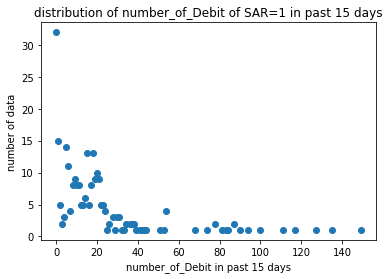

In [34]:
feature = 'number_of_Debit'
day = 15
label = 1
DrawFeatureDistribution(SAR, feature, day, label)

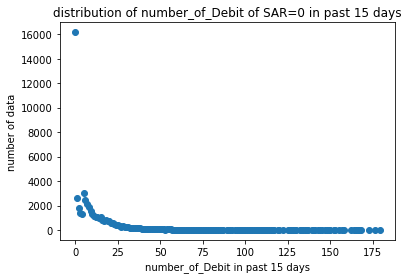

In [36]:
feature = 'number_of_Debit'
day = 15
label = 0
DrawFeatureDistribution(Non_SAR, feature, day, label)

In [37]:
# debit 提款, 小於等於{次數}留下, SAR=0 number of Debit值較大, upper bound
# train 
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

threshold_range4 = np.arange(20, 220, 20)
for thre in threshold_range4:
    new_SAM_1 = train_set[train_set['number_of_Debit']<=thre] 
    new_SAM_0 = train_set[train_set['number_of_Debit']>thre]
    TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
    TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
    FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
    FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
    total = train_set.shape[0]
    results = results.append({'threshold':thre, 'SAR':SAR.shape[0], \
                              'Non SAR':Non_SAR.shape[0],\
                              'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                              'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                              'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,20,267,51794,193,44851,74,6942,0.7228,0.1348
1,40,267,51794,240,50372,27,1421,0.8989,0.0278
2,60,267,51794,250,51478,17,315,0.9363,0.0064
3,80,267,51794,254,51649,13,144,0.9513,0.003
4,100,267,51794,262,51686,5,107,0.9813,0.0022
5,120,267,51794,264,51733,3,60,0.9888,0.0012
6,140,267,51794,266,51760,1,33,0.9963,0.0007
7,160,267,51794,267,51779,0,14,1.0,0.0003
8,180,267,51794,267,51793,0,0,1.0,0.0
9,200,267,51794,267,51793,0,0,1.0,0.0


In [38]:
# debit 提款, 低於多少次數留下
# test 
results = pd.DataFrame(columns = ['threshold','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])

thre = 60

new_SAM_1 = test_set[test_set['number_of_Debit']<=thre] 
new_SAM_0 = test_set[test_set['number_of_Debit']>thre]
TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
total = test_set.shape[0]
results = results.append({'threshold':thre, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                          'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                          'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                          'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                          'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)
display(results)

,threshold,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
0,60,179,34530,167,34286,12,244,0.933,0.0074
